In [1]:
import torch 
import torch.nn.functional as F
from torch.utils.data import DataLoader
from src import full_pcd_dataset
import importlib
importlib.reload(full_pcd_dataset)
import json
# Create dataset instance
dataset = full_pcd_dataset.FullPCDDataset("data/full_pcd_300000_samples_6d.npz")
with open("data/label_dict.json", "r") as f:
    label_dict = json.load(f)
num_classes = len(label_dict.keys())
# Split into train and validation (example: 80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from pathlib import Path
import numpy as np
import open3d as o3d

model_dir = Path("data/models")
model_list = list(model_dir.glob("*"))
model_list

[WindowsPath('data/models/combwrench.obj'),
 WindowsPath('data/models/drill.obj'),
 WindowsPath('data/models/hammer.obj'),
 WindowsPath('data/models/screwdriver.obj'),
 WindowsPath('data/models/wrench.obj')]

In [3]:
dataset.point_clouds[0]
dataset.transformations[0]
dataset.labels[0]

0

In [4]:
initial_pcd_list = []
for path in model_list:
    model = o3d.io.read_triangle_mesh(str(path)).compute_vertex_normals()
    pcd = model.sample_points_poisson_disk(number_of_points=1000)
    initial_pcd_list.append(pcd)



In [5]:
# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0,pin_memory=True)
num_classes

5

In [6]:
from src.model_updated import PointNet2Classification 
from torch.optim.lr_scheduler import StepLR
# backbone_params = {"sa_mlps": [[2, 2, 2], [2, 2, 2]], "mlp":[64, 128, 256], "downsample_points": [256, 64], "radii":[0.1, 0.15], "ks":[16, 32], "add_xyz":True}

check_model = PointNet2Classification(num_classes, backbone_params=None, emb_mode=False)
backbone_params = { "downsample_points": [1000, 1000],"mlp":[64, 128, 128]}

point_model = PointNet2Classification(num_classes, backbone_params=backbone_params, emb_mode=True)


In [7]:
# checkpoint = torch.load('cls_updated_vsmall_new_data_2/checkpoint_epoch_30.pth', map_location='cpu')  # Load on CPU to avoid GPU memory issues
# saved_state_dict = checkpoint['model_state']
state = torch.load('cls_updated_vsmall_new_data_4/best_model.pth', map_location='cpu')  # Load on CPU to avoid GPU memory issues
saved_state_dict = state



In [8]:
check_model.load_state_dict(saved_state_dict)
point_model.load_state_dict(saved_state_dict)

<All keys matched successfully>

In [9]:
check_model.eval()
point_model.eval()
n_item = 5
with torch.no_grad():
    result = check_model(None, dataset[n_item][0].unsqueeze(0))
    new_pcd_emb = point_model(None, dataset[n_item][0].unsqueeze(0))
    pcd = torch.from_numpy(np.asarray(initial_pcd_list[result.argmax(dim=1).item()].points)).float()
    initial_pcd_emb = point_model(None, pcd.unsqueeze(0))
    print(result.argmax(dim=1).item(), dataset[n_item][1][0])

2 tensor(2)


In [10]:
new_pcd_emb

tensor([[[ 0.0307,  0.8262,  0.3296,  ...,  0.1046, -0.1141,  0.9886],
         [ 0.0824,  0.3407,  0.0110,  ...,  0.1578, -0.2645,  1.0045],
         [ 1.4587,  1.1896,  1.1600,  ...,  0.1662, -0.3610,  1.0134],
         ...,
         [ 0.7990,  0.8054,  1.9149,  ...,  0.0849, -0.1869,  1.0021],
         [ 0.8671,  0.5700,  0.5239,  ...,  0.0571, -0.1434,  0.9927],
         [ 0.1516,  0.1726,  0.0098,  ...,  0.1442, -0.2431,  1.0122]]])

In [19]:
ii = 72

new_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(new_pcd_emb[0,:,-3:].cpu().numpy()))
new_pcd.paint_uniform_color([0.5, 0.5, 0.5])  # Set color for new point cloud
initial_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(initial_pcd_emb[0,:,-3:].cpu().numpy()))
initial_pcd.paint_uniform_color([0.5, 0.5, 0.5])  # Set color for new point cloud

new_pcd_point =o3d.geometry.PointCloud(o3d.utility.Vector3dVector(new_pcd_emb[0,ii,-3:].unsqueeze(0).cpu().numpy()))
new_pcd_point.paint_uniform_color([1, 0, 0])  # Set color for new point cloud point


# idx = torch.matmul(initial_pcd_emb[0,:,:-3], new_pcd_emb[0,1,:-3]).argmax(dim=0).item()
idx = torch.matmul(F.normalize(initial_pcd_emb[0,:,:-3],p=2,dim=1), F.normalize(new_pcd_emb[0,ii,:-3],p=2,dim=0)).argmax(dim=0).item()
point = np.expand_dims(initial_pcd_emb[0,:,-3:].cpu().numpy()[idx],0)
initial_pcd_point =o3d.geometry.PointCloud(o3d.utility.Vector3dVector(point))
initial_pcd_point.paint_uniform_color([1, 0, 0])  # Set color for new point cloud point



PointCloud with 1 points.

In [20]:
torch.matmul(F.normalize(new_pcd_emb[0,:,:-3],p=2,dim=1), F.normalize(new_pcd_emb[0,ii,:-3],p=2,dim=0)).argmax(dim=0).item()

72

In [35]:
# Get indices of top 10 largest values
topk_values, topk_indices = torch.topk(torch.matmul(F.normalize(initial_pcd_emb[0,:,:-3],p=2,dim=1), F.normalize(new_pcd_emb[0,ii,:-3],p=2,dim=0)), k=50)  # k=10 for top 10

print("Top 10 indices:", topk_indices)
print("Top 10 values:", topk_values)

initial_pcd_emb[0,topk_indices,-3:].cpu().numpy()
initial_pcd_points =o3d.geometry.PointCloud(o3d.utility.Vector3dVector(initial_pcd_emb[0,topk_indices,-3:].cpu().numpy()))
initial_pcd_points.paint_uniform_color([1, 0, 0])

Top 10 indices: tensor([318, 223, 773, 197, 593,  10, 440, 686, 252,  77, 921,  38, 421, 375,
        384, 317, 266, 379, 278, 299,  32, 378, 100, 373, 227, 262, 859, 647,
        589, 808, 521, 820, 216, 184, 542, 829,  78, 161,  98, 964,  45, 121,
        834, 320, 937, 641,  94, 206, 539, 668])
Top 10 values: tensor([0.9459, 0.9429, 0.9394, 0.9393, 0.9378, 0.9370, 0.9366, 0.9353, 0.9332,
        0.9331, 0.9325, 0.9319, 0.9306, 0.9301, 0.9292, 0.9282, 0.9280, 0.9277,
        0.9273, 0.9260, 0.9254, 0.9218, 0.9213, 0.9209, 0.9197, 0.9179, 0.9169,
        0.9164, 0.9151, 0.9144, 0.9139, 0.9120, 0.9116, 0.9115, 0.9110, 0.9110,
        0.9107, 0.9103, 0.9101, 0.9090, 0.9084, 0.9083, 0.9079, 0.9076, 0.9075,
        0.9073, 0.9070, 0.9066, 0.9065, 0.9046])


PointCloud with 50 points.

In [14]:
torch.matmul(F.normalize(initial_pcd_emb[0,:,:-3],p=2,dim=1), F.normalize(new_pcd_emb[0,ii,:-3],p=2,dim=0))

tensor([0.6082, 0.6733, 0.6271, 0.6591, 0.7242, 0.7875, 0.7571, 0.6881, 0.7208,
        0.7810, 0.8134, 0.7215, 0.6901, 0.8188, 0.6880, 0.7145, 0.8264, 0.6934,
        0.7618, 0.6194, 0.8125, 0.7697, 0.8003, 0.6552, 0.8091, 0.6009, 0.7133,
        0.8218, 0.8012, 0.8109, 0.8653, 0.7870, 0.8514, 0.7565, 0.8422, 0.6232,
        0.5832, 0.8193, 0.8034, 0.8271, 0.8556, 0.8274, 0.7724, 0.7382, 0.6902,
        0.8037, 0.8076, 0.5939, 0.6583, 0.5952, 0.8123, 0.8074, 0.7881, 0.7370,
        0.8178, 0.7318, 0.7593, 0.8396, 0.7735, 0.7894, 0.7803, 0.6475, 0.8361,
        0.8067, 0.7412, 0.8809, 0.7819, 0.5786, 0.7935, 0.7702, 0.6880, 0.5860,
        0.7681, 0.8328, 0.8089, 0.7731, 0.8019, 0.8186, 0.8331, 0.8419, 0.8266,
        0.8244, 0.6692, 0.6408, 0.7790, 0.8645, 0.6873, 0.4719, 0.5379, 0.6720,
        0.8081, 0.7947, 0.7297, 0.6968, 0.8796, 0.7638, 0.6536, 0.8100, 0.7876,
        0.7956, 0.8216, 0.8098, 0.5980, 0.6504, 0.6499, 0.7467, 0.8065, 0.7783,
        0.7747, 0.5709, 0.8116, 0.6960, 

In [18]:
for i in range(1000):
    similarity_vector = torch.matmul(F.normalize(initial_pcd_emb[0,:,:-3],p=2,dim=1), F.normalize(new_pcd_emb[0,i,:-3],p=2,dim=0)) 
    if torch.max(similarity_vector) > 0.94:
        print(f"Point {i} has high similarity with the reference point.")


Point 72 has high similarity with the reference point.
Point 302 has high similarity with the reference point.
Point 480 has high similarity with the reference point.
Point 896 has high similarity with the reference point.


In [ ]:
# initial_pcd_emb[0,topk_indices,-3:].cpu().numpy()
# initial_pcd_points =o3d.geometry.PointCloud(o3d.utility.Vector3dVector(initial_pcd_emb[0,topk_indices,-3:].cpu().numpy()))
# initial_pcd_points.paint_uniform_color([1, 0, 0])

PointCloud with 10 points.

In [39]:
o3d.visualization.draw_geometries([new_pcd_point, new_pcd , initial_pcd])


In [37]:
o3d.visualization.draw_geometries([initial_pcd_points,initial_pcd])

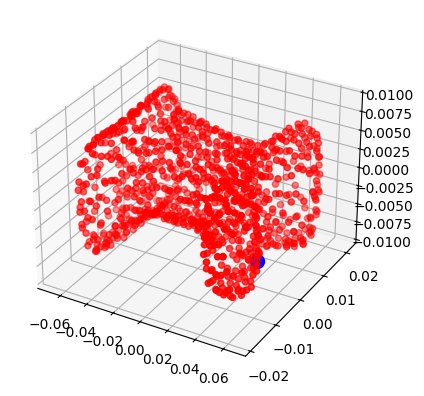

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract points
points1 = np.asarray(initial_pcd.points)
points2 = np.asarray(initial_pcd_point.points)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot with different sizes
ax.scatter(points1[:,0], points1[:,1], points1[:,2], c='r', s=20)  # s=size
ax.scatter(points2[:,0], points2[:,1], points2[:,2], c='b', s=100)  # s=size

plt.show()

In [51]:
initial_pcd_point

PointCloud with 1 points.

In [31]:
o3d.utility.Vector3dVector(new_pcd_emb[0,0,-3:].unsqueeze(0).cpu().numpy())

std::vector<Eigen::Vector3d> with 1 elements.
Use numpy.asarray() to access data.

In [34]:
torch.matmul(initial_pcd_emb[0,:,:-3], new_pcd_emb[0,0,:-3]).argmax(dim=0)

tensor(900)

In [21]:
initial_pcd_list[result.argmax(dim=1).item()]

std::vector<Eigen::Vector3d> with 1000 elements.
Use numpy.asarray() to access data.